In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Dataset ImageFolder
    Number of datapoints: 12614
    Root location: ../input/casia-dataset/CASIA2
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomChoice(
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=[0.5, 1.5], contrast=[0.5, 1.5], saturation=[0.5, 1.5], hue=None)
           )(p=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 001/002 ] loss = 0.68479, acc = 0.58539


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 001/002 ] loss = 0.69106, acc = 0.53524
[ Valid | 001/002 ] loss = 0.69106, acc = 0.53524 -> best
Best model found at epoch 0, saving model


  0%|          | 0/789 [00:00<?, ?it/s]

[ Train | 002/002 ] loss = 0.66263, acc = 0.60250


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 002/002 ] loss = 0.69088, acc = 0.53569
[ Valid | 002/002 ] loss = 0.69088, acc = 0.53569 -> best
Best model found at epoch 1, saving model


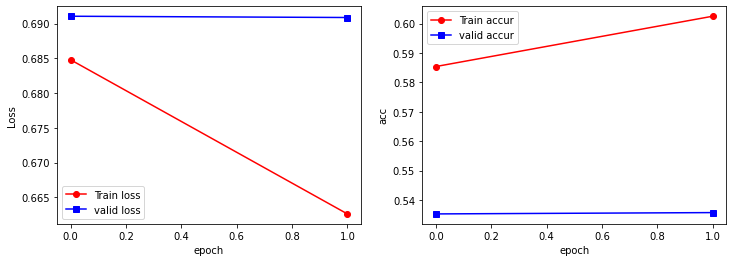

模型保存于2022-09-02_01_08_47


In [2]:
# -*- coding = utf-8 -*-
# @Time : 2022/8/30 9:50
# @Author : DL
# @File : test_residual.py
# @Software : PyCharmimport time
import time

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# This is for the progress bar.
from tqdm.auto import tqdm


# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.RandomChoice([transforms.RandomRotation(45), transforms.ColorJitter(0.5, 0.5, 0.5)]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

batch_size = 16

train_set = ImageFolder("../input/casia-dataset/CASIA2", transform=train_tfm)
valid_set = ImageFolder("../input/casia-dataset/CASIA1", transform=test_tfm)



train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer7 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
        )
        self.cnn_layer8 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
        )
        self.cnn_layer9 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),  # [512, 8, 8]
            nn.BatchNorm2d(512),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(inplace=True),  # accelerate
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )
        self.relu = nn.ReLU()
        self.mp = nn.MaxPool2d(2, 2, 0)

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        x1 = self.relu(x1)
        x1 = self.mp(x1)
        x2 = self.cnn_layer2(x1)
        x2 = self.relu(x2+x1)

        x3 = self.cnn_layer3(x2)
        x3 = self.relu(x3)
        x3 = self.mp(x3)
        x4 = self.cnn_layer4(x3)
        x4 = self.relu(x4+x3)

        x5 = self.cnn_layer5(x4)
        x5 = self.relu(x5)
        x5 = self.mp(x5)
        x6 = self.cnn_layer6(x5)
        x6 = self.relu(x6+x5)

        x7 = self.cnn_layer7(x6)
        x7 = self.relu(x7)
        x7 = self.mp(x7)
        x8 = self.cnn_layer8(x7)
        x8 = self.relu(x8 + x7)

        x9 = self.cnn_layer9(x8)
        x9 = self.mp(x9)

        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x9.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout


if __name__ == '__main__':
    print(train_set)
    # load_imgname(train_imgpath, test_imgpath)

    # "cuda" only when GPUs are available.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Initialize a model, and put it on the device specified.
    model = Residual_Network().to(device)
    model.device = device

    # For the classification task, we use cross-entropy as the measurement of performance.
    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # The number of training epochs.
    n_epochs = 2

    # Whether to do semi-supervised learning.
    do_semi = False

    patience = 500

    train_loss_epoch = []
    train_acc_epoch = []
    valid_loss_epoch = []
    valid_acc_epoch = []

    enter_ = 1
    enter_2 = 1

    best_acc = 0
    stale = 0

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        # if do_semi:
        #     # Obtain pseudo-labels for unlabeled data using trained model.
        #     # pseudo_set = get_pseudo_labels(unlabeled_set, model)
        #
        #     # Construct a new dataset and a data loader for training.
        #     # This is used in semi-supervised learning only.
        #     concat_dataset = ConcatDataset([train_set, pseudo_set])
        #     train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))
            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc.item())

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        train_loss_epoch.append(train_loss)
        train_acc_epoch.append(train_acc)


        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):
            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        valid_loss_epoch.append(valid_loss)
        valid_acc_epoch.append(valid_acc)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        _exp_name = "Residual_Network"
        # update logs
        if valid_acc > best_acc:
            with open(f"./{_exp_name}_log.txt", "a"):
                print(
                    f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
        else:
            with open(f"./{_exp_name}_log.txt", "a"):
                print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(model.state_dict(),
                       f"{_exp_name}_best.ckpt")  # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f"No improvement {patience} consecutive epochs, early stopping")
                break

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(n_epochs), train_loss_epoch,
             "ro-", label="Train loss")
    plt.plot(range(n_epochs), valid_loss_epoch,
             "bs-", label="valid loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(range(n_epochs), train_acc_epoch,
             "ro-", label="Train accur")
    plt.plot(range(n_epochs), valid_acc_epoch,
             "bs-", label="valid accur")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.show()

    time_finish = time.strftime('%Y-%m-%d_%H_%M_%S', time.localtime())
    print("模型保存于" + time_finish)